In [3]:
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt

# high quality figures 
plt.rcParams['figure.dpi'] = 200

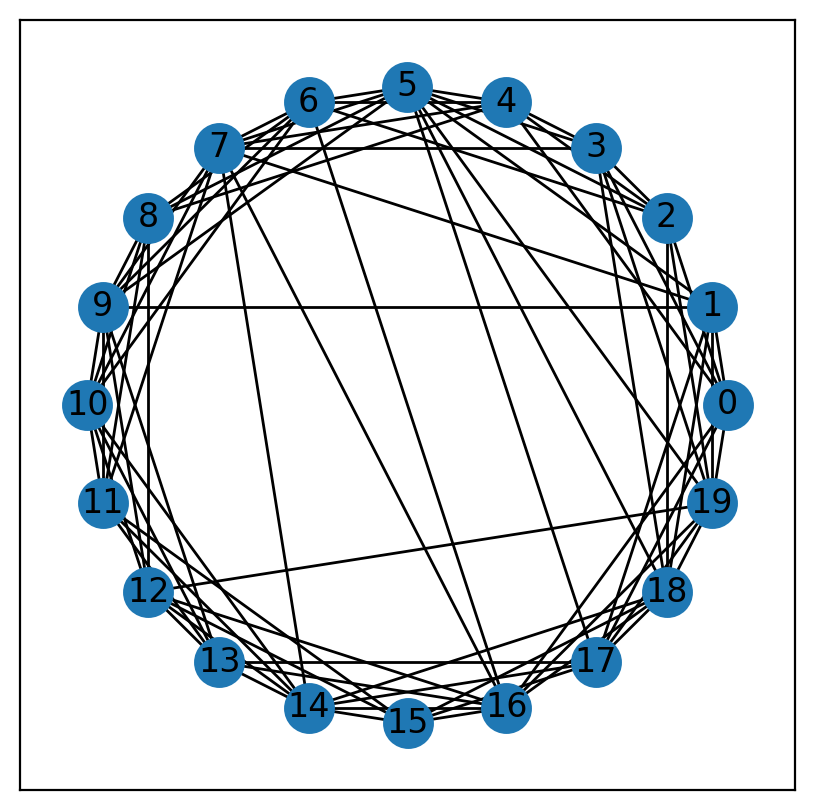

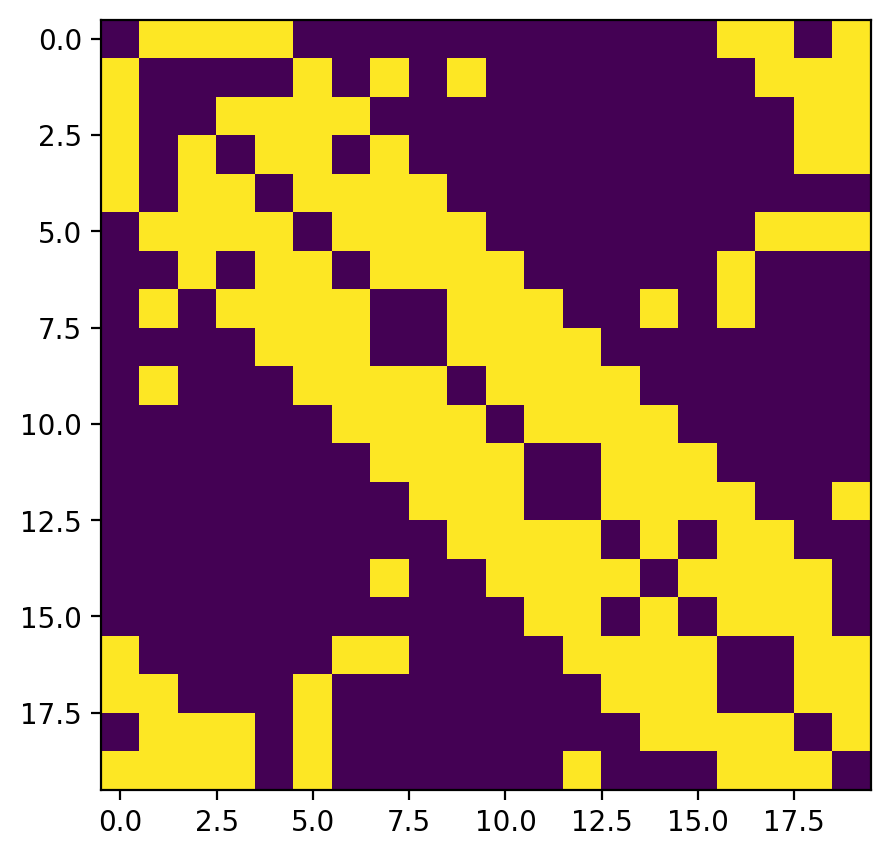

In [4]:
# generate adjacency matrix a_{ij} for an undirected Watts-Strogatz graph
N = 20; k = 4; p = 0.1;

A = np.zeros((N,N))

# generate ring graph (20 nodes)
for ii in range(N):
  for jj in range(-k,k):
      A[ii,np.mod(ii+jj,N)] = 1

# randomize
for ii in range(N):
  for jj in range(-k,k):
    if ( np.random.rand() < p ):
      
      # remove original edge (both directions)
      A[ii,np.mod(ii+jj,N)] = 0
      A[np.mod(ii+jj,N),ii] = 0

      index_target = np.random.randint( 0, N )
      while ( A[index_target,ii] == 1 and index_target != ii ): # avoid multiple edges and self loops 
        index_target = np.random.randint( 0, N )

      # add new edge (both directions)
      A[index_target,ii] = 1
      A[ii,index_target] = 1

# remove self loops
for ii in range(N):
  A[ii,ii] = 0

# visualize graph
G = nx.from_numpy_array(A)
pos = nx.circular_layout(G)
plt.figure(figsize = (5, 5))
nx.draw_networkx(G, pos)
plt.show()

# image plot
plt.figure(figsize = (5, 5))
plt.imshow( nx.to_numpy_array(G) )
plt.show()

### Clustering Coefficient

The clustering coefficient provides a way to quantify how tightly local communities in the network are connected together. For an undirected graph, the clustering coefficient captures how many of a node's neighbors are also connected to each other.

For a node $i$ in an undirected graph, the local clustering coefficient $C_i$ is defined as:

$$C_i=\frac{1}{k_i\left(k_i-1\right)} \sum_{j, k} a_{i j} a_{j k} a_{k i}$$

where $\mathbf{A}$ is the adjacency matrix of the graph, and $k_i$ is the degree of node $i$. The numerator counts the number of triangles that include node $i$, while the denominator counts the maximum possible number of such triangles, given the node's degree.

This definition has an intuitive interpretation in social networks: if person A knows B and C , what is the probability that B and C also know each other? A high clustering coefficient indicates that a person's friends are likely to be friends with each other, forming tight-knit social groups.

We can evaluate this expression for the clustering coefficient using the code below.

In [5]:
# define function for generating Watts-Strogatz graph
def generate_watts_strogatz( N = 20, k = 4, p = 0.0 ):
  
  A = np.zeros((N,N))
  
  # generate ring graph
  for ii in range(N):
    for jj in [x for x in range(-k,k) if x != 0]:
        A[ii,np.mod(ii+jj,N)] = 1
  
  # randomize
  for ii in range(N):
    for jj in range(-k,k):
      if ( np.random.rand() < p ):
        
        A[ii,np.mod(ii+jj,N)] = 0
        A[np.mod(ii+jj,N),ii] = 0
  
        index_target = np.random.randint( 0, N )
        while ( A[index_target,ii] == 1 ):
          index_target = np.random.randint( 0, N )
  
        A[index_target,ii] = 1
        A[ii,index_target] = 1
        
  return A

# generate graph and calculate clustering coefficient for a single node
N = 20; k = 4; p = 0.0
A = generate_watts_strogatz( N, k, p )

ii = 11; degree = np.sum( A[ii,:] ); numerator = 0;
for jj in range( N ):
  for kk in range( N ):
    numerator += A[ii,jj]*A[jj,kk]*A[kk,ii]
Ci = numerator / ( degree * ( degree - 1 ) )

# print calculated result
print( "Clustering coefficient...", Ci )

Clustering coefficient... 0.6428571428571429


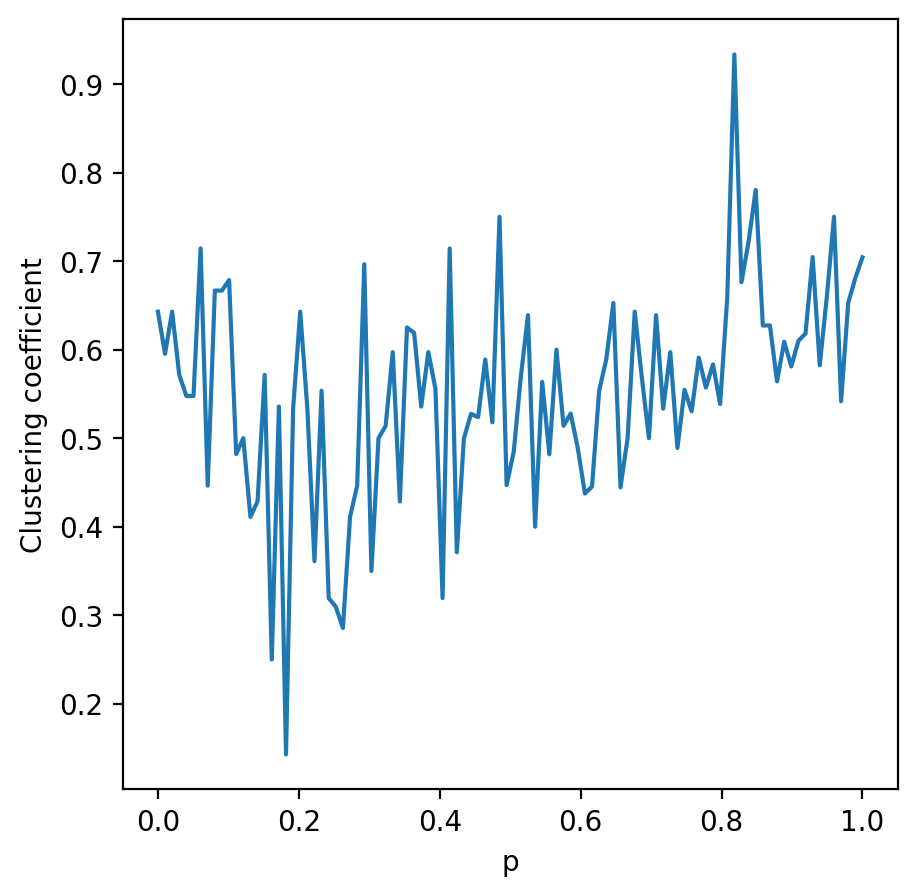

In [6]:
# Plot the clustering coefficient for a given node as a function of p
p_values = np.linspace(0, 1, 100)
Ci_values = np.zeros(p_values.shape)

for idx, p in enumerate(p_values):  # Iterate over all p values
    A = generate_watts_strogatz(N, k, p)
    degree = np.sum(A[ii, :])  # Keep node ii fixed
    numerator = 0
    for jj in range(N):
        for kk in range(N):
            numerator += A[ii, jj] * A[jj, kk] * A[kk, ii]
    Ci_values[idx] = numerator / (degree * (degree - 1))

plt.figure(figsize=(5, 5))
plt.plot(p_values, Ci_values)
plt.xlabel("p")
plt.ylabel("Clustering coefficient")
plt.show()


### Average Path Length 

As introduced in the lecture, nodes in a network can be connected either directly through a single edge, or indirectly through a sequence of edges that forms a path through other nodes. For example, information spreads through a social network either by a message traveling directly between friends, or passing through several intermediate acquaintances to reach its destination. Each such sequence of connections forms a path through the network.

Among all possible paths between two nodes, we are often most interested in the shortest ones. These paths represent the most efficient routes through the network. In social networks, they might represent the quickest way for information to spread between two people. In transportation networks, they could represent the fastest route between two cities. In the Internet, they often correspond to the actual routes that data packets take.

The length of the shortest path between two nodes gives us a concrete measure of how "far apart" they are in the network structure again, in a relational sense, not necessarily related to their physical proximity. We can organize all these shortest paths into a distance matrix $\mathbf{D}$, where each entry $d_{i j}$ represents the length of the shortest path between nodes $i$ and $j$. For directly connected nodes, $d_{i j}=1$. For nodes connected through one intermediate node, $d_{i j}=2$, and so on.

For connected graphs (where there exists a path between any two nodes), we can compute the average path length $L$ by summing over all entries in the distance matrix and dividing by the total number of possible node pairs:

$$L=\frac{1}{N_C} \sum_{i, j} d_{i j}$$

where $N_C=N(N-1)$ is the number of possible connected node pairs. Note that, for the purposes of this introduction, we will consider only graphs that are connected, meaning that isolated "islands" of nodes are rare. This restriction means that, while nodes with no path between them are typially assigned a distance of infinity, we will not need to consider these values here.

We can calculate the average path length using the average_shortest_path_length function provided in Networkx using the code below.

In [7]:
# define function for generating Watts-Strogatz graph
def generate_watts_strogatz( N = 20, k = 4, p = 0.0 ):
  
  A = np.zeros((N,N))
  
  # generate ring graph
  for ii in range(N):
    for jj in [x for x in range(-k,k) if x != 0]:
        A[ii,np.mod(ii+jj,N)] = 1
  
  # randomize
  for ii in range(N):
    for jj in range(-k,k):
      if ( np.random.rand() < p ):
        
        A[ii,np.mod(ii+jj,N)] = 0
        A[np.mod(ii+jj,N),ii] = 0
  
        index_target = np.random.randint( 0, N )
        while ( A[index_target,ii] == 1 ):
          index_target = np.random.randint( 0, N )
  
        A[index_target,ii] = 1
        A[ii,index_target] = 1
        
  return A

# generate Watts-Strogatz graph  
N = 400; k = 4; p = 0.0
A = generate_watts_strogatz( N, k, p )

# calculate average shortest path
G = nx.from_numpy_array(A)
d = nx.average_shortest_path_length(G)
print( "Average shortest path length...", d )

Average shortest path length... 25.43859649122807


### The Small World Effect 

With these two measures - clustering coefficient and average path length - we can now understand the insight from Watts and Strogatz in a precise way. The figure below shows what happens to these measures as we increase the rewiring probability $p$ in this network model.

What makes this result so interesting is to find the intermediate regime (approximately between $p=0.01$ and $p=0.1$ where the network maintains most of its clustering $(C(p) / C(0)$ remains close to 1) while simultaneously achieving the short average path lengths characteristic of random graphs $(L(p) / L(0)$ drops significantly). This is the small-world regime.

This was an important example of the concept of emergence in complex systems. Even though the total number of edges remains constant throughout the rewiring process, and even though we're changing only a small fraction of the connections, the global properties of the network transform dramatically. The small-world effect isn't a property of any individual node or edge - it emerges from the pattern of connections itself. We will explore more examples of this type of phenomenon as we go throughout the course.

Using the code developed above for constructing Watts-Strogatz graphs and calculating network metrics, investigate the emergence of the small-world effect:
1. Create a Watts-Strogatz graph with $N=200$ , $k=5$, and $p=0$
2. Calculate the clustering coefficient $C$ and average path length $L$ for this graph.
3. Try different values of $p$.
4. Identify the range of $p$ where you observe the small-world regime

Consider:
- How many edges are actually being rewired in the small-world regime?
- How does this compare to the total number of edges $\left(\mathrm{N}^* \mathrm{k} / 2\right)$ ?
- Why might such a small number of rewired edges have such a dramatic effect on path lengths?

In [8]:
# create a watts-strogatz graph with N = 200, k = 5, and p = 0.0
N = 200; k = 5; p = 0.0
A = generate_watts_strogatz(N, k, p)

# calculate the clustering coefficient C and the average shortest path length L for the graph
G = nx.from_numpy_array(A)
C = nx.average_clustering(G)
L = nx.average_shortest_path_length(G)

# print the results
print("Clustering coefficient...", C)
print("Average shortest path length...", L)

Clustering coefficient... 0.666666666666668
Average shortest path length... 10.452261306532664
